In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3909, done.
remote: Counting objects: 100% (3909/3909), done.
remote: Compressing objects: 100% (3016/3016), done.
remote: Total 3909 (delta 1129), reused 1996 (delta 840), pack-reused 0
Receiving objects: 100% (3909/3909), 49.65 MiB | 31.17 MiB/s, done.
Resolving deltas: 100% (1129/1129), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 21.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to bui

In [4]:

!pip uninstall numpy -y
!pip install numpy==1.22

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 61.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3, but you have numpy 1.22.0 which is incompatible.
tensorflow-model-optimization 0.7.5 requires numpy~=1.23, but you have numpy 1.22.0 which is incompatible.


In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
!unzip /content/model_trained.zip

Archive:  /content/model_trained.zip
   creating: models_trained/
   creating: models_trained/my_ssd_mobnet/
  inflating: models_trained/my_ssd_mobnet/checkpoint  
  inflating: models_trained/my_ssd_mobnet/ckpt-1.data-00000-of-00001  
  inflating: models_trained/my_ssd_mobnet/ckpt-1.index  
  inflating: models_trained/my_ssd_mobnet/ckpt-2.data-00000-of-00001  
  inflating: models_trained/my_ssd_mobnet/ckpt-2.index  
  inflating: models_trained/my_ssd_mobnet/ckpt-3.data-00000-of-00001  
  inflating: models_trained/my_ssd_mobnet/ckpt-3.index  
   creating: models_trained/my_ssd_mobnet/eval/
  inflating: models_trained/my_ssd_mobnet/eval/events.out.tfevents.1686026862.DESKTOP-ETS0QUN.4728.0.v2  
   creating: models_trained/my_ssd_mobnet/export/
   creating: models_trained/my_ssd_mobnet/export/checkpoint/
  inflating: models_trained/my_ssd_mobnet/export/checkpoint/checkpoint  
  inflating: models_trained/my_ssd_mobnet/export/checkpoint/ckpt-0.data-00000-of-00001  
  inflating: models_train

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('/content/models_trained/my_ssd_mobnet/pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('/content/models_trained/my_ssd_mobnet', 'ckpt-3')).expect_partial()

@tf.function()
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [12]:
category_index = label_map_util.create_category_index_from_labelmap('/content/label_map.pbtxt')

In [9]:
IMAGE_PATH = '/content/WhatsApp Image 2023-06-10 at 16.03.23.jpeg'

In [25]:
def testing(img_path, threshold):
  img = cv2.imread(IMAGE_PATH)
  image_np = np.array(img)

  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
  #input_tensor = tf.convert_to_tensor(np.expand_dims(img, 0), dtype=tf.float32)
  #input_tensor = tf.image.decode_png(tf.io.read_file(IMAGE_PATH), channels=3)[tf.newaxis, ...]

  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
  detections['num_detections'] = num_detections

  # detection_classes should be ints.
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=100,
            min_score_thresh=threshold,
            agnostic_mode=False)

  plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
  plt.show()
  detect_score = detections['detection_scores']
  return detect_score

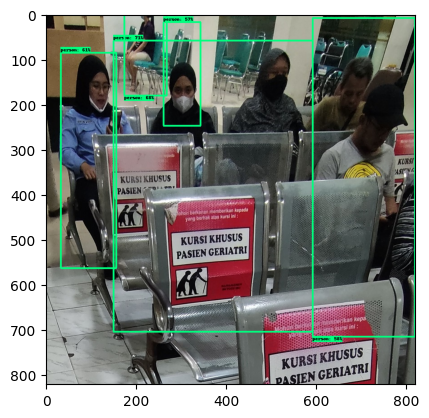

array([0.7116159 , 0.6751316 , 0.61012477, 0.581772  , 0.5689285 ,
       0.45513937, 0.41819492, 0.3394838 , 0.32207808, 0.29777202,
       0.29655153, 0.29025668, 0.27446374, 0.2705191 , 0.22357213,
       0.21799129, 0.21170343, 0.1981323 , 0.18289834, 0.17884399,
       0.1742553 , 0.17241578, 0.16460088, 0.16164647, 0.15600649,
       0.14706339, 0.13226555, 0.13202733, 0.13046038, 0.13003656,
       0.12997846, 0.12317722, 0.12126372, 0.12012142, 0.10991112,
       0.10883063, 0.10613748, 0.10579752, 0.10429445, 0.10380437,
       0.10186946, 0.10162997, 0.09831541, 0.09812903, 0.0979406 ,
       0.09770336, 0.09564507, 0.09471966, 0.09241042, 0.09209689,
       0.09107643, 0.09081633, 0.09042086, 0.08731042, 0.08479746,
       0.08430413, 0.08407485, 0.08364235, 0.08293916, 0.07979607,
       0.07909322, 0.07441033, 0.07337051, 0.07259817, 0.0725285 ,
       0.07117175, 0.07104769, 0.06903896, 0.06817032, 0.06758196,
       0.06715463, 0.06670933, 0.06649593, 0.06637818, 0.06613

In [26]:
testing(IMAGE_PATH,0.5)

In [27]:
def count_person(score):
  terdeteksi = []
  for i in score:
    if i > 0.5:
      terdeteksi.append(i)
  return len(terdeteksi)

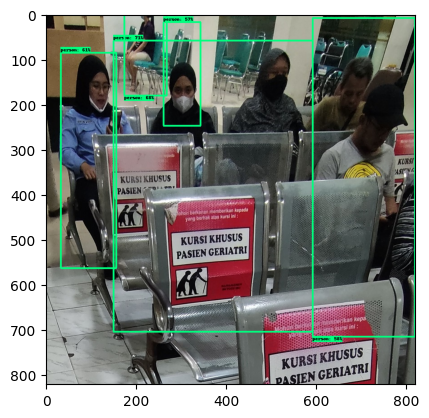

5

In [28]:
#jumlah orang terdeteksi
count_person(testing(IMAGE_PATH,0.5))